# Uczenie głębokie cz. I

Ten notatnik ma na celu przedstawienie jednego ze sposobów tworzenia głębokich sieci neuronowych w Pythonie. W trakcie zadania najpierw stworzymy prostą sieć konwolucyjną, a następnie zbadamy jej proces uczenia się. Na tych zajęciach wykorzystamy biblioteki [Keras](https://keras.io/) i [Tensorflow](https://www.tensorflow.org/).

Po wykonaniu tego zadania powinieneś:
+ wiedzieć z jakich części składają się sieci konwolucyjne,
+ potrafić uruchomić sieć neuronową na własnych danych,
+ wiedzieć jak wczytać i wykorzystać gotowy model,
+ zwizualizować i śledzić na żywo proces uczenia się sieci.

## Prosta sieć konwolucyjna

Najpierw załadujemy odpowiednie biblioteki i wczytamy mały zbiór obrazów do uczenia się rozpoznawania liczb.

**Zad. 1:Przejrzyj komentarze przy operacjach `import`, aby zapoznać się z nazewnictwem w bibliotece Keras.**

In [1]:
import numpy as np
np.random.seed(23)

import tensorflow as tf
tf.random.set_seed(23)

from matplotlib import pyplot as plt

# Typ sieci
from tensorflow.keras.models import Sequential # tworzymy typową sieć jednokierunkową (bez rekurencji)

# Typy warstw
from tensorflow.keras.layers import Dense # warstwa z w pełni połączona (wszystkie neurony z poprzedniej warstwy do każdego w kolejnej)
from tensorflow.keras.layers import Dropout # mechanizm losowego wyłączania neuronów (pozwala uniknąć przeuczenia)
from tensorflow.keras.layers import Activation # aktywacja, czyli funkcja przyjmująca jedną liczbę (np. sigmoid, softmax)
from tensorflow.keras.layers import Flatten # spłaszczenie wejścia (np. zamiana tensora o wymiarach 64x32x32 na wektor o długości 65536)
from tensorflow.keras.layers import Conv2D # warstwa konwolucyjna, tworzy filtry o zadanym rozmiarze w zadanych odstępach
from tensorflow.keras.layers import MaxPooling2D # warstwa zmniejszająca obraz poprzez operacje max na zadanym rozmiarze pikseli

# Optymalizator i funkcja straty
from tensorflow.keras import optimizers
from tensorflow.keras import losses

# "Przydasie"
from tensorflow.keras import utils as k_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import time

Czas na zbiór danych. Skorzystamy ze standardowego zbioru treningowego do omawiania sieci konwolucyjnych, czyli [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór składa się z małych obrazków, więc będziemy w stanie nauczyć sieć na zwykłym komputerze, a sieci konwolucyjne są tu jak najbardziej potrzebne do uzyskania sensownych wyników.

Biblioteka Keras ma funkcję pobierającą ten zbiór z sieci, z czego skrzętnie skorzystamy.

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 6s 0us/step


**Zad. 2: Sprawdź jakie wymiary mają załadowane obrazki. Przypisz te wartości do zmiennych img_rows, img_cols. Sprawdź również liczbę klas i przypisz tę wartość to zmiennej `num_classes`.**

In [8]:
# sprawdź wymiary zbioru danych

img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
num_classes = len(set(y_train))

**Zad. 3: Wyświetl pierwszy rysunek ze zbior.**

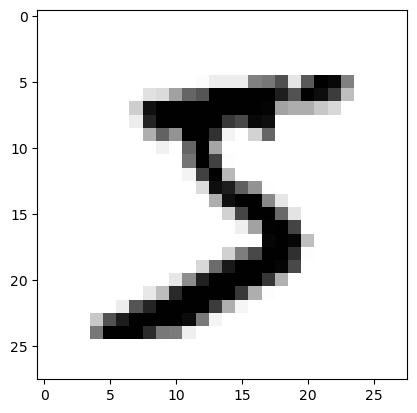

In [9]:
plt.imshow(X_train[0], cmap='binary')

## Wstępne przetwarzanie danych

Ponieważ obrazy mogą mieć różną liczbę kolorów (kanałów), musimy powiedzieć Kerasowi jaki format danych będzie przetwarzać. Obrazy mogą mieć jeden kanał (skala szarości), trzy kanały (RGB), a czasami więcej niż trzy kanały (np. zdjęcia satelitarne). Dane w zbiorze MNIST są zakodowane w skali szarości, a zatem mają jeden kanał.

**Zad. 4: Zmień wymiarowość danych wejściowych zgodnie z poniższym wzorem.**

In [ ]:
# X_train = X_train.reshape(X_train.shape[0], l_wierszy, l_kolumn, l_kanalow)
# X_test = X_test.reshape(X_test.shape[0], l_wierszy, l_kolumn, l_kanalow)
# input_shape = (l_wierszy, l_kolumn, l_kanalow)

Oprócz określenia wymiaru danych wejściowych musimy upewnić się, że są one typu `float32`. Ponadto warto ustandaryzować dane wejściowe lub sprowadzić je do zakresu [0-1]. My uczynimy to drugie.

In [ ]:
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

Ostatnia rzecz, którą musimy zrobić to zakodować klasy (`y`) w sposób binarny. Czyli zamiast klas `1, 2, ... 10` itd., chcemy uzyskać kodowanie w postaci `[1 0 0 0 0 0 0 0 0 0], [0 1 0 0 0 0 0 0 0 0] ... [0 0 0 0 0 0 0 0 0 1]`. W Kerasie posłuży nam do tego funkcja `to_categorical()`.

In [ ]:
# y_train = k_utils.to_categorical(y_train, num_classes)
# y_test = k_utils.to_categorical(y_test, num_classes)

## Tworzenie sieci

W Kerasie **architekturę sieci** definiuje się poprzez podanie typu sieci i kolejnych warstw. Dla każdej warstwy określa się typ neuronów, ich liczbę i (jeśli to konieczne) ich parametry.

Poniżej zdefiujemy prostą sieć konwolucyjną. Będzie się ona składała tylko z dwóch warstw konwolucyjnych, bo zdjęcia na których operujemy są bardzo małe. Większe zdjęcia wymagałyby więcej warstw. Uwaga! W uporszczeniu: im większa sieć tym większe wymagania pamięciowe i czasowe!

Nasza architektura to (porównaj z poniższym kodem):
- **warstwa konwolucyjna** tworząca **32 filtry** o rozmiarze **3x3**. Każdy filtr stanowi wejście dla funkcji atywacyjnej typu **ReLU**. Zauważ, że w pierwszej warstwie sieci musimy podać wymiary (warstwę wejściową). W kolejnych warstwach nie jest to konieczne, bo warstwy wiedzą jak mają się łączyć.
- **warstwa konwolucyjna** tworząca **64 filtry** o rozmiarze **3x3** z **ReLU**.
- **warstwa pooling** zmiejszająca obraz o połowę
- **warstwa dropout** losowo wyłączają 1/4 neuronów przy każdym przejściu
- **warstwę spłaszczającą** wielowymiarowe konwolucje w wektor
- **w pełni połączona warstwa** 128 neuronów
- **kolejny dropout**
- **warstwa wyjściowa** posiadającą tyle neuronów ile mamy klas

**Zad. 5: W ostatniej warstwie nie jest podana funkcja aktywacji. Wróć do slajdów i sprawdź jaka funkcja aktywacji nada się do klasyfikacji.**

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(num_classes, activation='?'))

Po stworzeniu sieci w Kerasie trzeba ją skompilować. W tym kroku Keras dostosowuje kod pod wykonanie na wybranym backendzie. W naszym przypadku będzie to Tensorflow, ale równie dobrze mogłyby to być platformy Theano lub CNTK.

Podczas kompilacji podajemy **funkcję straty**, **optymalizator**. Ponadto można podać szereg miar do śledzenia (typowo przy klasyfikacji accuracy).

**Zad. 6: Wróć do slajdów i sprawdź jaka funkcja straty nada się do klasyfikacji wieloklasowej. Jako optymalizator wybierz Adadelta, dzięki temu nie będziesz musiał podawać learning rate. Protip: użyj Tab.**

In [ ]:
# model.compile(loss=losses.?,
#               optimizer=optimizers.?,
#               metrics=['accuracy'])

## Uczenie sieci

Mamy sieć. Teraz nic tylko odpalić uczenie. Robiąc to musimy podać **batch_size** (czyli ile przykładów przepuszczamy przez sieć między aktualizacją wag) i liczbę **epok** (czyli ile razy chcemy przepuścić przez sieć cały zbiór danych). Zbiór walidacyjny będzie nam mówił na ile dobrze sieć działa na danych, których wcześniej nie widzieliśmy.

In [ ]:
# model.fit(X_train, y_train,
#           batch_size=128,
#           epochs=12,
#           verbose=1,
#           validation_data=(X_test, y_test))

# Jak kod ruszy, oszacuj ile zajmie uczenie sieci (ETA jednej epoki x liczba epok).
# Jeśli wychodzi Ci więcej niż 3 minuty zatrzymaj uczenie i czytaj dalej...

Spójrzmy na ETA. Aha, ale to tylko 1 epoka z 12... Hmmm.... Trochę będzie trzeba poczekać. Zatrzymaj powyższy blok kodu. Zaraz coś z tym zrobimy...

## GPU

Uczenie sieci to bardzo czasochłonny proces. Na szczeście, ze względu na swoją modularność, sieci bardzo łatwo się zrównolegla. Stąd gotowość większości bibliotek do współpracy z kartami graficznymi (jednakże obecnie są to praktycznie tylko karty NVidii).

Ponieważ prawdopodobnie nie masz komputera z super-ekstra kartą graficzną do obliczeń równoległych, skorzystamy z karty graficznej w chmurze. AWS, Google Cloud, Microsoft Azure chętnie udostępnią swoje moce obliczeniowe za drobną opłatą. Maszyny wirtualne z GPU są stosunkowo drogie w porównaniu do innych maszyn, ale przy naliczaniu godzinowym (a niekiedy sekundowym) jest to bardzo interesująca opcja. Jeśli masz dostęp do jednej z tych platform, albo lepiej dostęp i niewykorzystany kredyt, warto z tego skorzystać.

Aby zaoszczędzić sobie czasu nie będziemy stawiać pełnoprawnych wirtualek na żadnej z wymienionych platform. Zamiast tego proponuję szybko odpalić Google Colab (https://colab.research.google.com/) i tam wgrać ten notebook.
1. Wejdź na https://colab.research.google.com/.
2. Kliknij **Plik -> Prześlij notatnik**
3. Z menu **Środowisko wykonawcze** wybierz **Zmień typ środowiska wykonawczego** i wybierz maszynę z **GPU**
4. Zacznij odpalać kod

**Zad 7. Wykonaj powyższe kroki i naucz sieć z tego notebooka na GPU. Po zakończeniu obliczeń zapisz model do pliku za pomocą poniższego kodu. Następnie ściągnij utworzony plik modelu i zamknij zdalnego Jupytera.**

In [ ]:
# model.save("gpu_cnn_model.keras")

## Wczytywanie modelu i predykcje

Uczenie się trwa długo, ale jak już mamy nauczoną sieć to wcale nie zajmuje ona aż tyle miejsca na dysku i działa bardzo szybko. Sprawdźmy czy tak rzeczywiście jest.

**Zad. 8: Wczytaj model nauczony na GPU na swoim lokalnym komputerze i dokonaj predykcji zgodnie z poniższym szablonem.**

In [ ]:
# %%time
# gpu_model = load_model("gpu_cnn_model.keras") # w razie co do projektu jest też załączony wcześniej nauczony "cnn_model"

In [ ]:
# %%time
# score = gpu_model.evaluate(X_test, y_test, verbose=0)
# print('{0} przykładów'.format(X_test.shape[0]))
# print('loss={0:.4f}, accuracy={1:.4f}'.format(score[0], score[1]))

U mnie na laptopie wyszło ok. 9 sekund. Dzieląc to przez liczbę przykładów wychodzi 10000/9 = 1111 obrazów na sekundę, czyli nie tak źle. Zwłaszcza, że mój komputer ma ponad 5 lat.

## Tensorboard

Tensorflow udostępnia świetne narzędzie do wizualizacji procesu uczenia sieci o nazwie **Tensorboard**. Aby je uruchomić odpal Anaconda Prompt i wpisz następujące polecenie:

```
tensorboard --logdir="pelna_sciezka_do_tego_notebooka/logs"
```
Jeżeli korzystasz z Colaba odkomentuj odpowiednie komórki (z komentarzem tylko w colabie).

In [ ]:
#tylko w colabie
#%load_ext tensorboard


**Zad. 9: Odpal Tensorboarda a następnie uruchom (lokalnie) poniższy kod. W trakcie gdy sieć się uczy wejdź na stronę Tensorboard i sledź zmiany.**

In [ ]:
# epochs = 12
# batch_size = 128
# dataset_size = 1000

# # Protip: w nazwie modelu zawrzyj wartości parametrów, wtedy będzie można łatwo porównywać różne architektury/parametry
# model_name = "cpu_cnn_model" + \
#     "_e=" + str(epochs) + "_b=" + str(batch_size) + \
#     "_n=" + str(dataset_size) + "_t=" + time.strftime("%Y%m%d_%H%M%S", time.localtime())

# tb_callback = TensorBoard(log_dir="./logs/" + model_name, histogram_freq=-1)

# model.fit(X_train[:dataset_size,:,:,:], y_train[:dataset_size,:],
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test[:dataset_size,:,:,:], y_test[:dataset_size,:]),
#           callbacks=[tb_callback])

In [ ]:
#tylko w colabie
#%tensorboard --logdir logs

**Zad. 10: Zmień batch size na 64, zbuduj i skompiluj ponownie sieć (kod z zad. 5 i 6) i odpal uczenie jeszcze raz. Porównaj krzywe uczenia w Tensorboard.**

Poznałeś podstawy tego co jest potrzebne aby nauczyć własną głęboką sieć neuronową od zera. O tym jakie inne architektury zaproponowano do różnych zadań i jak przyspieszyć proces uczenia sieci dla wielu standardowych problemów dowiesz się w kolejnym notebooku.